In [1]:
# %%capture
# pip install econml shap "flaml[automl]" dill plotnine scikit-misc patchworklib

In [2]:
import warnings
warnings.simplefilter('ignore')

In [3]:
import joblib
import dill as pickle

import pandas as pd
import numpy as np

from econml.dml import CausalForestDML, SparseLinearDML
from econml.dr import SparseLinearDRLearner, ForestDRLearner
from econml.metalearners import XLearner, TLearner, SLearner

from sklearn.base import BaseEstimator, clone
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LassoCV, LinearRegression, ElasticNetCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.base import clone, BaseEstimator, clone
from sklearn.model_selection import StratifiedGroupKFold, GroupKFold, KFold, StratifiedKFold, cross_val_predict, cross_val_score, train_test_split, GroupShuffleSplit
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures

import flaml
from flaml import AutoML

import matplotlib.pyplot as plt
import plotnine as p9
import patchworklib as pw
import shap
import math

import scipy
import scipy.special
from statsmodels.api import OLS

<Figure size 100x100 with 0 Axes>

In [4]:
df = pd.read_parquet('../../output/pretraining/representations_combo_df.parquet')
df.columns

Index(['mrn', 'ds', 'g_7dr', 'very_low_7dr', 'low_7dr', 'in_range_7dr',
       'high_7dr', 'very_high_7dr', 'gri_7dr', 'g_14dr', 'very_low_14dr',
       'low_14dr', 'in_range_14dr', 'high_14dr', 'very_high_14dr', 'gri_14dr',
       'night_very_low_7dr', 'night_low_7dr', 'night_high_7dr',
       'night_very_high_7dr', 'day_very_low_7dr', 'day_low_7dr',
       'day_high_7dr', 'day_very_high_7dr', 'time_worn_7dr', 'night_worn_7dr',
       'day_worn_7dr', 'gri_7dr_7d_delta', 'very_low_7dr_7d_delta',
       'low_7dr_7d_delta', 'in_range_7dr_7d_delta', 'very_high_7dr_7d_delta',
       'night_very_low_7dr_7d_delta', 'night_low_7dr_7d_delta',
       'night_high_7dr_7d_delta', 'delta_in_range_fw_7d', 'delta_gri_fw_7d',
       'sexF', 'public_insurance', 'english_primary_language', 'pop_pilot',
       'pop_4T_1', 'pop_4T_2', 'pop_TIPS', 'age', 'months_since_onset',
       'using_pump', 'using_aid', 'data_split', 'large_tir_drop', 'low_tir',
       'lows', 'very_lows', 'umap0', 'umap1', 'umap2', 

New features for filtering

In [5]:
# Drop rows with no flags
print(df.shape)
df = df[(df.low_tir+df.lows+df.very_lows+df.large_tir_drop)>0]
print(df.shape)

(196816, 82)
(129345, 82)


AutoML Wrappers

In [6]:
# We want to only use W variables when fitting and precting with nuisance models.
# In EconML, the X [features for CATE] and W [features for nuisances] are h-stacked. 
# We want to only us the W features (i.e. last W.shape[0] columns of XW)
# https://github.com/py-why/EconML/blob/main/econml/dml/dml.py#L44


###################################
# AutoML models
###################################

# FLAML models don't return "self" at end of fit. We create this wrapper.

class AutoMLWrap(BaseEstimator):

    def __init__(self, *, model, automl, features, filter_feats):
        self.model = model
        self.automl = automl
        self.features = features
        self.filter_feats = filter_feats

    def fit(self, X, y, **kwargs):
        self.model_ = clone(self.model)
        Xf = X[:,-len(self.features):] if self.filter_feats else X
        self.model_.fit(Xf, y, **kwargs)
        return self

    def predict(self, X):
        Xf = X[:,-len(self.features):] if self.filter_feats else X
        return self.model_.predict(Xf)

# Custom r2 loss for regression, for more trustworthy learning curves.
def reg_r2(
        X_val, y_val, estimator, labels,
        X_train, y_train, weight_val=None, weight_train=None,
        *args,):
    mse = np.mean((estimator.predict(X_val) - y_val)**2)
    r_2 = 1-mse/np.mean((y_val - y_val.mean())**2)
    return -1*r_2, {"val_loss": r_2}

def auto_reg(X, y, *, features,
             groups=None, n_splits=5, split_type='auto', time_budget=60, verbose=0, 
             estimator_list='auto', log_file_name='flaml_log.txt'):
    X = np.array(X)
    automl = AutoML(task='regression', time_budget=time_budget, early_stop=True,
                    eval_method='cv', n_splits=n_splits, split_type=split_type,
                    metric=reg_r2, verbose=verbose, estimator_list=estimator_list)
    if groups is None:
        automl.fit(X, y, log_file_name=log_file_name)
    else:
        automl.fit(X, y, groups=groups, log_file_name=log_file_name)
    best_est = automl.best_estimator
    return lambda x=False: AutoMLWrap(model=clone(automl.best_model_for_estimator(best_est)), automl=automl, features=features, filter_feats=x)


class AutoMLWrapCLF(BaseEstimator):

    def __init__(self, *, model, automl, prop_lb, features, filter_feats):
        self.model = model
        self.automl = automl
        self.prop_lb = prop_lb
        self.features = features
        self.filter_feats = filter_feats

    def fit(self, X, y, **kwargs):
        self.model_ = clone(self.model)
        Xf = X[:,-len(self.features):] if self.filter_feats else X
        self.model_.fit(Xf, y, **kwargs)
        return self

    def predict(self, X):
        Xf = X[:,-len(self.features):] if self.filter_feats else X
        preds = self.model_.predict_proba(Xf) 
        preds = np.clip(preds, self.prop_lb, 1-self.prop_lb)
        return preds
    
    def predict_proba(self, X):
        Xf = X[:,-len(self.features):] if self.filter_feats else X
        preds = self.model_.predict_proba(Xf) 
        preds = np.clip(preds, self.prop_lb, 1-self.prop_lb)
        return preds

# Custom r2 loss for classification, for more trustworthy learning curves.
def clf_r2(
        X_val, y_val, estimator, labels,
        X_train, y_train, weight_val=None, weight_train=None,
        *args,):
    mse = np.mean((estimator.predict_proba(X_val)[:, 1] - y_val)**2)
    r_2 = 1-mse/np.mean((y_val - y_val.mean())**2)
    return -1*r_2, {"val_loss": r_2}

def clf_mod_log_loss(
    X_val, y_val, estimator, labels,
    X_train, y_train, weight_val=None, weight_train=None,
    *args,):
    
    preds = estimator.predict_proba(X_val)[:,1]

    mod_log_loss = np.mean(-1* ( (.01 + y_val)*np.log(preds) + (1.01 - y_val)*np.log(1-preds)))

    return mod_log_loss, {"val_loss": mod_log_loss}

def auto_clf(
        X, y, *, features,
        groups=None, n_splits=5, split_type='auto', time_budget=60, verbose=0, estimator_list='auto', 
        log_file_name='flaml_log.txt', prop_lb=0.02):
    X = np.array(X)
    automl = AutoML(task='classification', time_budget=time_budget, early_stop=True,
                    eval_method='cv', n_splits=n_splits, split_type=split_type,
                    metric='log_loss', verbose=verbose, estimator_list=estimator_list,
                   )
    if groups is None:
        automl.fit(X, y, log_file_name=log_file_name)
    else:
        automl.fit(X, y, groups=groups, log_file_name=log_file_name)
    best_est = automl.best_estimator
    return lambda x=False: AutoMLWrapCLF(model=clone(automl.best_model_for_estimator(best_est)), automl=automl, prop_lb=prop_lb, features=features, filter_feats=x)

In [7]:
# Split data

groups = df.mrn.values

train, val = next(GroupShuffleSplit(n_splits=2, train_size=.33, random_state=123).split(df, groups=groups))
train_mrns = groups[train]
val_mrns = groups[val]
print(train_mrns.shape)
print(np.unique(train_mrns).shape)

val, test = next(GroupShuffleSplit(n_splits=2, train_size=.5, random_state=123).split(val_mrns, groups=val_mrns))
test_mrns = val_mrns[test]
val_mrns = val_mrns[val]
print(val_mrns.shape)
print(np.unique(val_mrns).shape)
print(test_mrns.shape)
print(np.unique(test_mrns).shape)

df_train = df.iloc[train].copy()
df_val = df.iloc[val].copy()
df_test = df.iloc[test].copy()

(42799,)
(92,)
(46795,)
(93,)
(39751,)
(94,)


In [8]:
TIDE_VARS = [
    'very_low_7dr', 'low_7dr', 'in_range_7dr', 'g_7dr', 'using_pump',
    'in_range_7dr_7d_delta', 'large_tir_drop',
    'low_tir', 'lows', 'very_lows', 
    'pop_4T_1', 'pop_4T_2', 'pop_TIPS', 
]

In [9]:
# Fit nuisance models

TESTING = False
PROP_LB = 0.01

time_budget = 1 if TESTING else 300 
verbose = 1  # verbosity of auto-ml
n_splits = 10 # cross-fitting and cross-validation splits

X = df_train[TIDE_VARS].astype(float).to_numpy()
Y = df_train['delta_in_range_fw_7d'].values
D = df_train['recommends_insulin_dose_change'].values
groups = df_train.mrn.values

# AutoML Models
model_y = auto_reg(
    X, Y, features=TIDE_VARS, groups=groups, n_splits=n_splits, split_type='auto',
    verbose=verbose, time_budget=time_budget, estimator_list=['rf'])
model_t = auto_clf(
    X, D, features=TIDE_VARS, groups=groups, n_splits=n_splits, split_type='auto',
    verbose=verbose, time_budget=time_budget, estimator_list=['rf'], prop_lb=PROP_LB)
model_reg_one = auto_reg(
    X[D==1], Y[D==1], features=TIDE_VARS, groups=groups[D==1], n_splits=n_splits, split_type='auto',
    verbose=verbose, time_budget=time_budget, estimator_list=['rf'])

# Load pickled stuff

# with open(f'../../output/analysis/reps_grid_search_5/model_y.pkl', 'rb') as f:
#     model_y = pickle.load(f)
    
# with open(f'../../output/analysis/reps_grid_search_5/model_t.pkl', 'rb') as f:
#     model_t = pickle.load(f)
    
# with open(f'../../output/analysis/reps_grid_search_5/model_reg_one.pkl', 'rb') as f:
#     model_reg_one = pickle.load(f)

# Test
print(model_y(True).fit(X, Y).predict(X))
print(model_reg_one(True).fit(X, Y).predict(X))
print(model_t(True).fit(X, D).predict(X))

[-0.25779717 -0.14907843 -0.02788975 ...  0.06568362  0.06512751
  0.03615438]
[0.02841699 0.05915502 0.07971693 ... 0.01696734 0.01848108 0.01183945]
[[0.9727705  0.0272295 ]
 [0.96502198 0.03497802]
 [0.95407283 0.04592717]
 ...
 [0.97921469 0.02078531]
 [0.97921469 0.02078531]
 [0.9791326  0.0208674 ]]


In [10]:
# # Save models

# with open(f'../../output/analysis/reps_grid_search_5/model_y.pkl', 'wb') as f:
#     pickle.dump(model_y, f)
    
# with open(f'../../output/analysis/reps_grid_search_5/model_t.pkl', 'wb') as f:
#     pickle.dump(model_t, f)

# with open(f'../../output/analysis/reps_grid_search_5/model_reg_one.pkl', 'wb') as f:
#     pickle.dump(model_reg_one, f)

# Functions

In [11]:
# Estimate CATE function
def est_cate_fn(estimator_name, prop_lb, model_y, model_t, Y, X, W, D, n_splits, groups):
    
    if estimator_name == 'CF':
        est = CausalForestDML(
            discrete_treatment=True,
            model_t=model_t(True),
            model_y=model_y(True),
            use_ray=False,
            cv=GroupKFold(n_splits=n_splits),
            random_state=123,
            # Same default params as grf Causal Forest
            n_estimators=4 if TESTING else 2000,
            min_balancedness_tol=0.45, # 0.05
            min_samples_split=1e-6,
            min_samples_leaf=20,
            max_features=min(math.ceil(math.sqrt(X.shape[1])) + 20, X.shape[1]),
            max_samples=0.5,
            subforest_size=2,
        )
        est.fit(Y, D, X=X, W=W, groups=groups)
    
    elif estimator_name == 'DRForest':
        est = ForestDRLearner(
            model_propensity=model_t(True),
            model_regression=model_y(True),
            random_state=123,
            cv=GroupKFold(n_splits=n_splits),
            min_propensity=prop_lb,
            n_estimators=4 if TESTING else 2000,
        )
        est.fit(Y, D, X=X, W=W, groups=groups)
        
    elif estimator_name == 'XLearner':
        est = XLearner(
            models = model_y(),
            cate_models = model_y(),
            propensity_model = model_t(True)
        )
        est.fit(Y, D, X=X)
    
    elif estimator_name == 'TLearner':
        est = TLearner(
            models = model_y(),
        )
        est.fit(Y, D, X=X)
        
    elif estimator_name == 'SLearner':
        est = SLearner(
            overall_model = model_y(),
        )
        est.fit(Y, D, X=X)
    
    return(est)

In [12]:
# Calculate multinomial DR scores
def calculate_dr_outcomes_mn(Xtrain, Dtrain, ytrain, groupstrain, Xval, Dval, yval, groupsval, model_t, model_reg_zero, model_reg_one, clipping):
    
    n = Dval.shape[0]
    n_treatments = Dtrain.max()
    # print(f'n_treatments: {n_treatments}')
    
    # 0) Fit propensity model and make predictions
    reg_prop = model_t(True).fit(Xtrain, Dtrain)
    reg_prop_preds = reg_prop.predict(Xval)
    # print(reg_prop_preds.shape)
    
    # 1) Fit control outcome model
    reg_zero = model_reg_zero(True).fit(Xtrain[list(Dtrain==0)], ytrain[list(Dtrain==0)])
    
    # 2) Fit treatment outcome models for each treatment
    reg_t = {t: model_reg_one(True).fit(Xtrain[list(Dtrain==t)], ytrain[list(Dtrain==t)]) for t in range(1,n_treatments+1)}
    
    # 3) Create control and treatment predictions
    reg_zero_preds_t = reg_zero.predict(Xval)[:,np.newaxis]
    reg_t_preds = {t: reg_t[t].predict(Xval) for t in range(1,n_treatments+1)}
    reg_t_preds = np.column_stack(list(reg_t_preds.values()))
    
    # 4) Calculate differences in predicted outcomes for each treatment relative to control
    reg_tau_hat = reg_t_preds - np.tile(reg_zero_preds_t, (1,n_treatments))
    
    # 5) Calculate residuals
    reg_preds_t = np.hstack([reg_zero_preds_t, reg_t_preds])[np.arange(n),Dval]
    reg_res = yval - reg_preds_t
    
    # 6) Calculate IPW adjustment with residuals
    reg_prop_preds_t = reg_prop_preds[np.arange(n), Dval]
    ipws = np.where(Dval>0,1,-1) * (1/reg_prop_preds_t)
    ipw_res_adj = (reg_res*ipws)
    
    # 7) DR scores
    dr_scores = reg_tau_hat
    dr_scores[np.arange(n),Dval-1] += ipw_res_adj
    
    return(dr_scores)

# Calc AUTOC and also return TOC curve
def toc_df(cate_est, dr_scores, colsuffix):
    
    # Calc ATE for offset
    ate = np.mean(dr_scores)
    
    # Grid of values of % treated 5-100%
    ugrid = np.linspace(0, 95, 39)
    
    # Quantiles of CATE est corresponding to each treated %
    qs = np.percentile(cate_est, ugrid)

    # Initialize vectors
    toc, toc_std, group_prob = np.zeros(len(qs)), np.zeros(len(qs)), np.zeros(len(qs))
    toc_psi = np.zeros((len(qs), dr_scores.shape[0])) # influence function representation of the TOC at each quantile
    
    # Iterate over %'s
    n = len(dr_scores)
    for it in range(len(qs)):
        inds = (qs[it] <= cate_est) # subset with larger CATE prediction than the q-th quantile
        group_prob = np.sum(inds) / n # fraction of population in this group
        toc[it]= np.mean(dr_scores[inds]) - ate # Rel ATT at %
        # influence function for the tau(q); it is a standard influence function of a "covariance"
        toc_psi[it, :] = (dr_scores - ate) * (inds / group_prob - 1) - toc[it]
        toc_std[it] = np.sqrt(np.mean(toc_psi[it]**2) / n) # standard error of tau(q)
        
    toc_df = pd.DataFrame({
        'p_treated': 100 - ugrid,
        'toc': toc,
        'toc_std': toc_std,
        'toc_lb': toc - 1.96*toc_std,
        'toc_ub': toc + 1.96*toc_std,
        'att': toc + ate,
        'att_lb': toc + ate - 1.96*toc_std,
        'att_ub': toc + ate + 1.96*toc_std,
        'type': np.repeat([colsuffix], len(ugrid))
    })
        
    # Calculate AUTOC
    autoc_psi = np.sum(toc_psi[:-1] * np.diff(ugrid).reshape(-1, 1) / 100, 0)
    autoc = np.sum(toc[:-1] * np.diff(ugrid) / 100)
    autoc_stderr = np.sqrt(np.mean(autoc_psi**2) / n)
    autoc_df = pd.DataFrame({
        f'AUTOC_{colsuffix}': [autoc],
        f'AUTOC_se_{colsuffix}' : [autoc_stderr]
    })
    
    return({
        'autoc_df': autoc_df,
        'toc_df': toc_df
    })


# Adapt TOC function to handle multiple treatments (3 options + 'best cate pred')

def toc_df_mn(mn_cate_est, mn_dr_scores, colsuffix):
    
    # Get DR scores of max CATE preds
    # Combine with DR scores for other treatments
    max_test_dr = mn_dr_scores[np.arange(len(mn_dr_scores)), np.argmax(mn_cate_est, axis=1)]
    all_drs = np.hstack([mn_dr_scores, max_test_dr[:,np.newaxis]])
    # ATEs
    # print(all_drs.mean(axis=0))

    # Create CATE predictions matrix incl max
    max_cate_preds = mn_cate_est.max(axis=1)
    all_cate_preds = np.hstack([mn_cate_est, max_cate_preds[:,np.newaxis]])
    
    # Iterate over treatments and compute toc_df separately for each one
    toc_dfs = []
    autoc_dfs = []
    for t in range(all_cate_preds.shape[1]):
        res = toc_df(all_cate_preds[:,t], all_drs[:,t], f'{colsuffix}_t{t+1}')
        autoc_dfs.append(res['autoc_df'])
        toc_dfs.append(res['toc_df'])
        
    toc_dfs = pd.concat(toc_dfs, axis=0)
    autoc_dfs = pd.concat(autoc_dfs, axis=1)
    return({
        'autoc_df': autoc_dfs,
        'toc_df': toc_dfs
    })

# Exploratory Plots


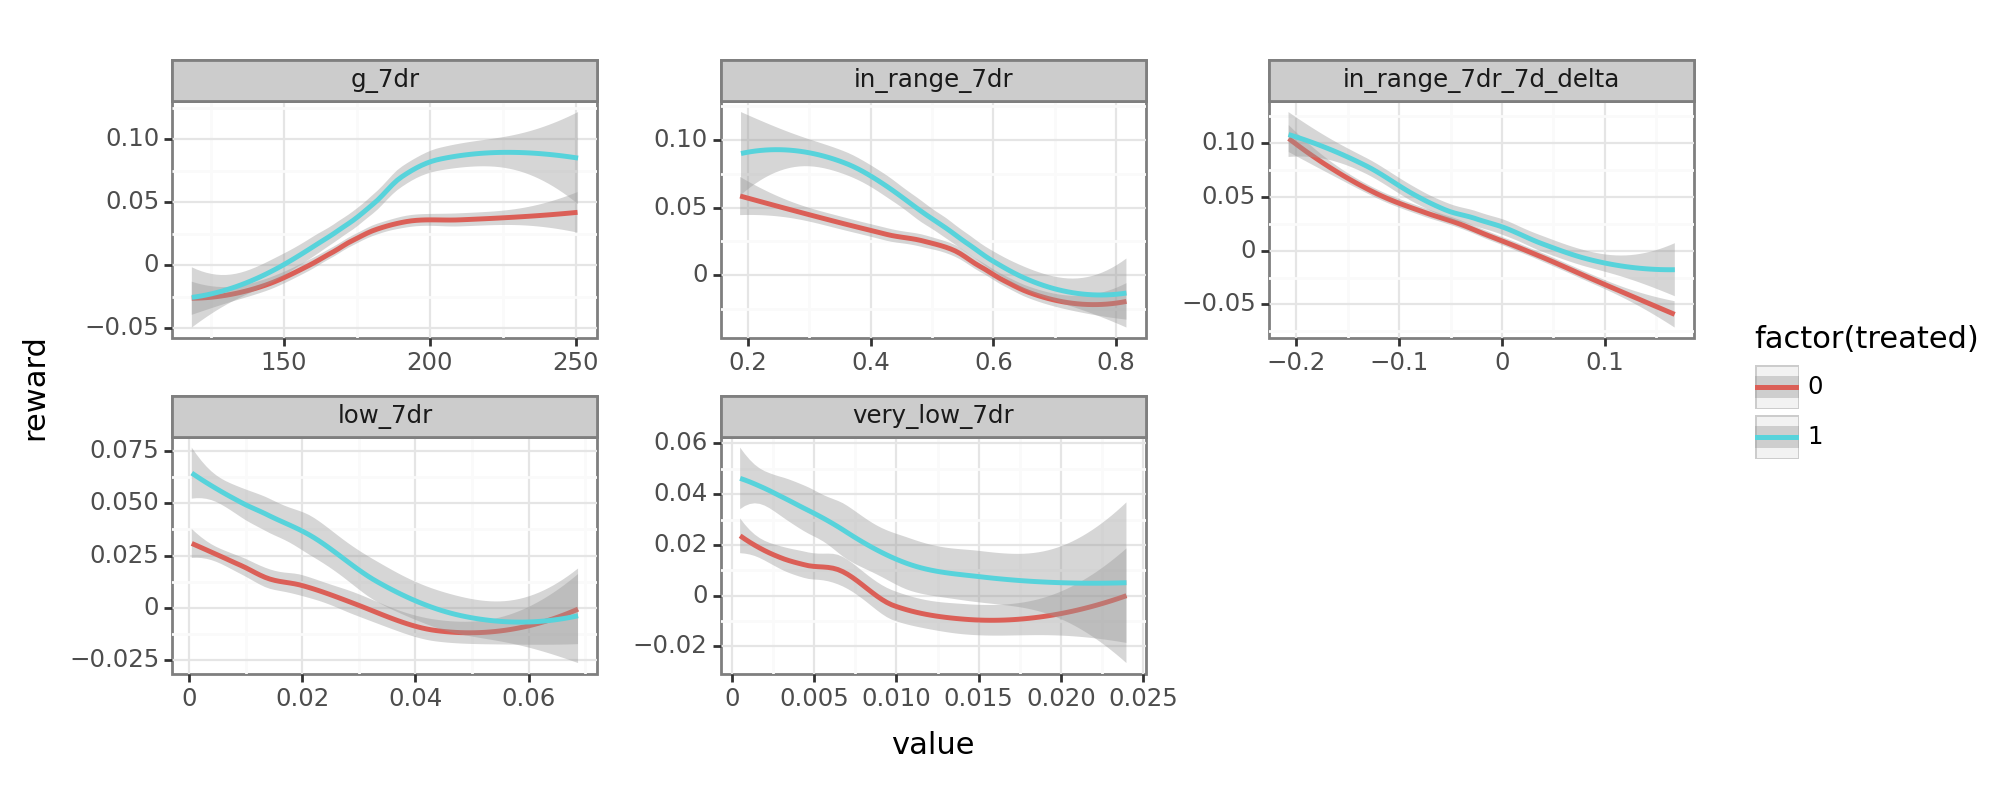

<Figure Size: (1000 x 400)>

In [13]:
df['reward'] = df.delta_in_range_fw_7d
df['treated'] = df.recommends_insulin_dose_change
melt_feats = ['reward','treated'] + TIDE_VARS

df_sample = pd.concat([
    df[df.treated==1],
    df[df.treated==0].sample(n=10000, random_state=123)
])

melt_plot_df = pd.melt(df_sample[melt_feats], id_vars=['reward','treated'])
melt_plot_df['value'] = melt_plot_df.value.astype(float)
melt_plot_df = melt_plot_df[~pd.isna(melt_plot_df.value)]
melt_plot_df['p95'] = melt_plot_df.groupby('variable')['value'].transform(lambda x: np.quantile(x,0.95))
melt_plot_df['p05'] = melt_plot_df.groupby('variable')['value'].transform(lambda x: np.quantile(x,0.05))

# Empirical Reward Plots
(p9.ggplot(
  melt_plot_df[(melt_plot_df.value<melt_plot_df.p95) & (melt_plot_df.value>melt_plot_df.p05)],
  p9.aes(x='value', y='reward', color='factor(treated)')) + 
  p9.facet_wrap('~variable', scales="free", ncol=3) + 
  p9.geom_smooth(method='loess') + p9.theme_bw() +
  p9.theme(figure_size=(10, 4))
)

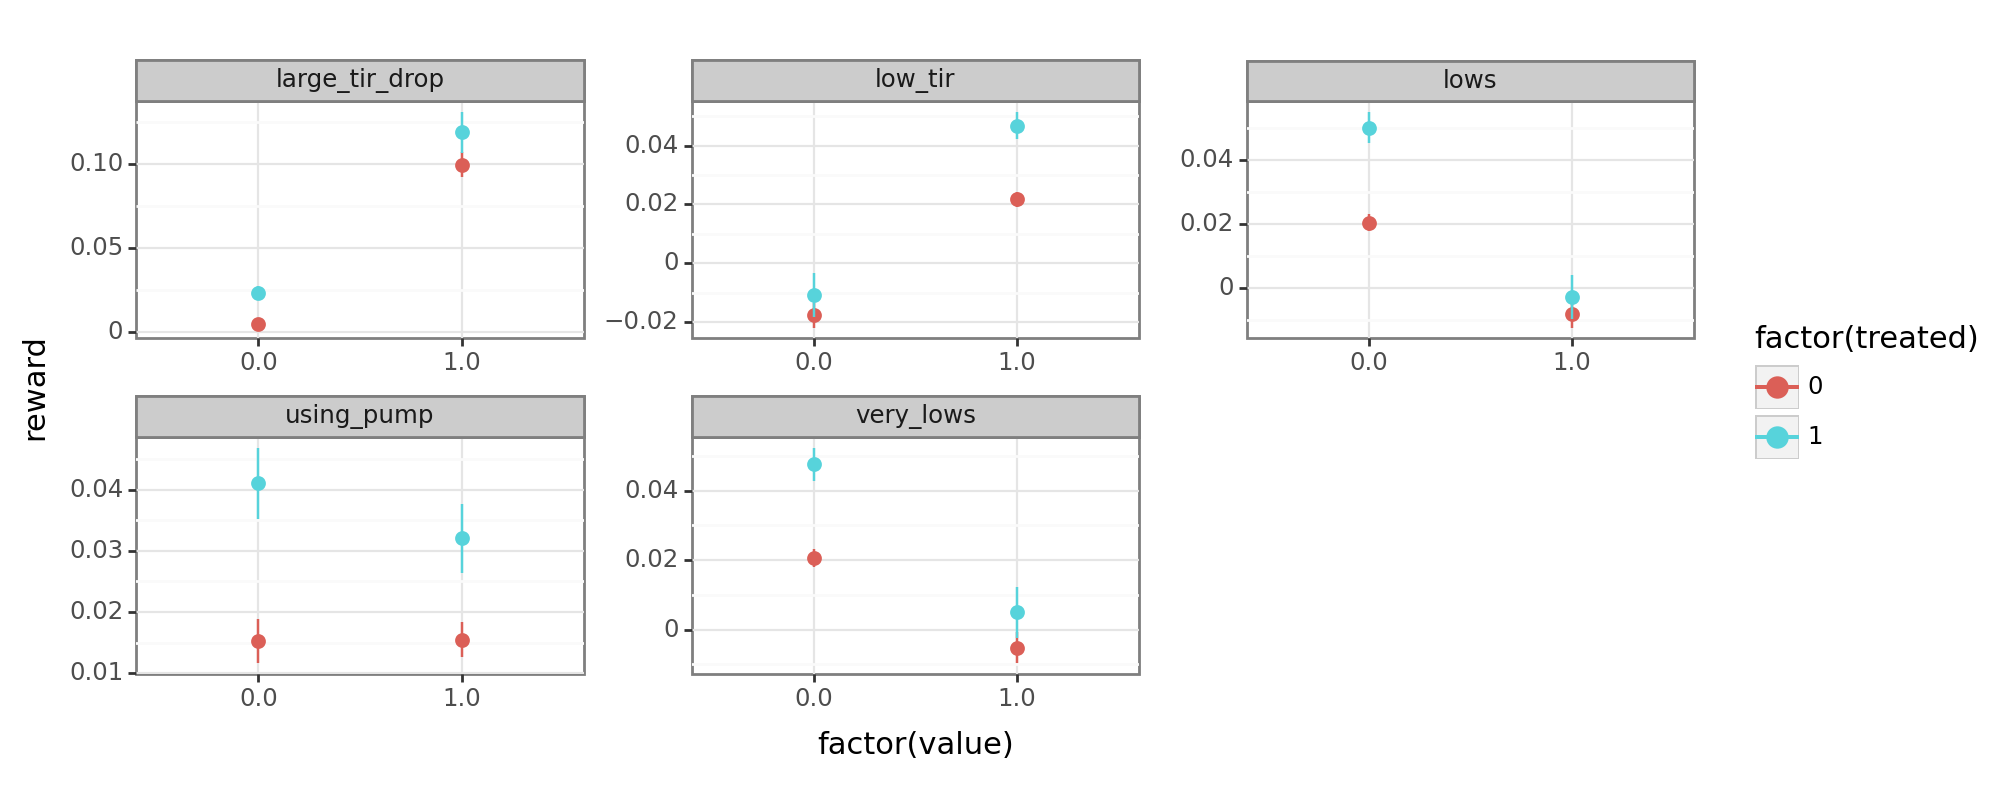

<Figure Size: (1000 x 400)>

In [14]:
# Binary features
(p9.ggplot(
  melt_plot_df[melt_plot_df.variable.isin(['using_pump','very_lows','low_tir','lows','large_tir_drop','very_lows'])],
  p9.aes(x='factor(value)', y='reward', color='factor(treated)')) + 
  p9.facet_wrap('~variable', scales="free", ncol=3) + 
  p9.stat_summary(fun_data='mean_cl_normal') + p9.theme_bw() +
  p9.theme(figure_size=(10, 4))
)

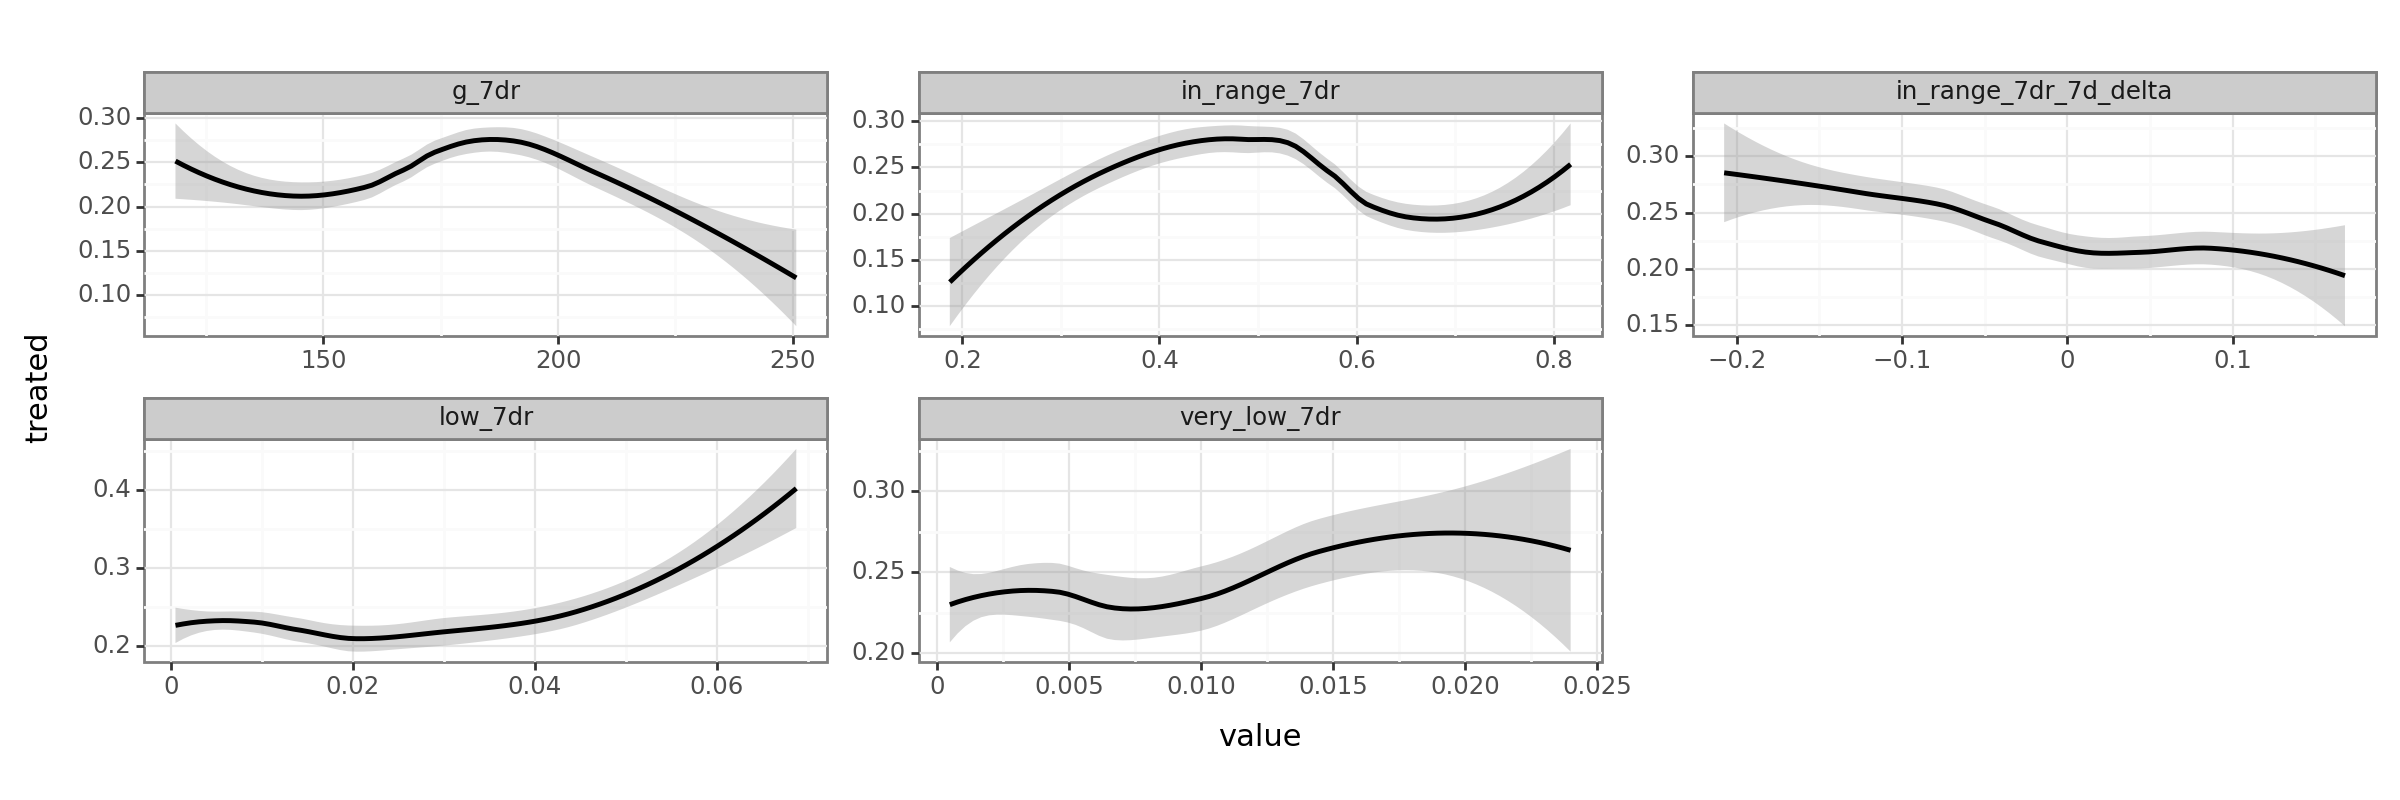

<Figure Size: (1200 x 400)>

In [15]:
# Empirical Propensity Plots
(p9.ggplot(
  melt_plot_df[(melt_plot_df.value<melt_plot_df.p95) & (melt_plot_df.value>melt_plot_df.p05)],
  p9.aes(x='value', y='treated')) + 
  p9.facet_wrap('~variable', scales="free", ncol=3) + 
  p9.geom_smooth(method='loess') + p9.theme_bw() + p9.theme(figure_size=(12, 4)))

In [16]:
STATE_REPS = {
    'TIDE': TIDE_VARS,
    'Expert (full)': ['g_7dr', 'very_low_7dr', 'low_7dr', 'in_range_7dr', 'high_7dr', 'very_high_7dr', 'gri_7dr', 'g_14dr', 'very_low_14dr', 'low_14dr', 'in_range_14dr', 'high_14dr', 'very_high_14dr', 'gri_14dr', 'night_very_low_7dr', 'night_low_7dr', 'night_high_7dr', 'night_very_high_7dr', 'day_very_low_7dr', 'day_low_7dr', 'day_high_7dr', 'day_very_high_7dr', 'time_worn_7dr', 'night_worn_7dr', 'day_worn_7dr', 'gri_7dr_7d_delta', 'very_low_7dr_7d_delta', 'low_7dr_7d_delta', 'in_range_7dr_7d_delta', 'very_high_7dr_7d_delta', 'night_very_low_7dr_7d_delta', 'night_low_7dr_7d_delta', 'night_high_7dr_7d_delta', 'sexF', 'public_insurance', 'english_primary_language', 'pop_pilot', 'pop_4T_1', 'pop_4T_2', 'pop_TIPS', 'age', 'months_since_onset', 'using_pump', 'days_since_msg', 'large_tir_drop', 'low_tir', 'lows', 'very_lows'],
    'Expert (subset)': ['large_tir_drop', 'in_range_7dr_7d_delta', 'in_range_14dr', 'in_range_7dr', 'low_7dr', 'using_pump', 'time_worn_7dr', 'day_worn_7dr', 'day_low_7dr', 'night_high_7dr_7d_delta', 'g_7dr', 'months_since_onset', 'gri_7dr_7d_delta'],
    'Raw (UMAP)': ['umap0', 'umap1', 'umap2', 'umap3', 'umap4', 'umap5']
}

ACTION_REPS = {
    'Binary (any)': 'received_message',
    'Binary (dose change)': 'recommends_insulin_dose_change',
    'Expert': 'custom_treatment',
    'Expert v2': 'custom_treatment_v2',
    'Expert v3': 'custom_treatment_v3',
    'Clustered Embeddings (2)': 'km_treatment_2',
    'Clustered Embeddings (3)': 'km_treatment_3',
    'Clustered Embeddings (4)': 'km_treatment_4',
}

In [17]:
# Comparison stats
print(df.shape)

(129345, 84)


In [ ]:
state_rep = 'TIDE'
action_rep = 'Expert v3'
outcome = 'delta_in_range_fw_7d'
cate_estimator = 'TLearner'
p_wins = 0.1
prop_lb = 0.01


####################
### PREPARE DATA ###
####################

# Define reward (outcome)
df['reward'] = df[outcome]
lb, ub = df.reward.quantile([p_wins, 1-p_wins])
df['reward'] = df.reward.clip(lb, ub)

X = df[STATE_REPS[state_rep]].astype(float).fillna(0.0).to_numpy()
W = df[TIDE_VARS].astype(float).to_numpy()
Y = df['reward'].values
D = df[ACTION_REPS[action_rep]].astype(int).values

groups = df.mrn.values

train, val = next(GroupShuffleSplit(n_splits=2, train_size=.33, random_state=123).split(X, Y, groups=groups))
X, Xval, D, Dval, Y, Yval, W, Wval = X[train], X[val], D[train], D[val], Y[train], Y[val], W[train], W[val]
groups, groupsval = groups[train], groups[val]

val, test = next(GroupShuffleSplit(n_splits=2, train_size=.5, random_state=123).split(Xval, Yval, groups=groupsval))
Xval, Xtest, Dval, Dtest, Yval, Ytest, Wval, Wtest = Xval[val], Xval[test], Dval[val], Dval[test], Yval[val], Yval[test], Wval[val], Wval[test]
groupsval, groupstest = groupsval[val], groupsval[test]

print(groups.shape)
print(np.unique(groups).shape)
print(groupsval.shape)
print(np.unique(groupsval).shape)
print(groupstest.shape)
print(np.unique(groupstest).shape)

##########################
### Fit CATE Estimator ###
##########################

# Train estimator
est = est_cate_fn(cate_estimator, prop_lb, model_y, model_t, Y, X, W, D, n_splits, groups)

# Make CATE predictions
cate_preds = []
for t in range(1, D.max()+1):
    cate_preds.append(est.effect(X,T1=t)[:,np.newaxis])
cate_preds = np.hstack(cate_preds)
print(cate_preds)

(42799,)
(92,)
(46795,)
(93,)
(39751,)
(94,)
[[ 0.12076255  0.1663882   0.10724107  0.15229786]
 [ 0.15363495  0.12156491  0.11108206  0.12833589]
 [ 0.14707796  0.07273283  0.10978541  0.07677093]
 ...
 [-0.02891705  0.0060364  -0.00796857 -0.02767534]
 [-0.03154503  0.00403876 -0.0040781  -0.01945737]
 [-0.04739484 -0.00304535 -0.00699324 -0.02646504]]


In [19]:
cate_preds.mean(axis=0)

array([0.00528174, 0.01636292, 0.01524141, 0.00525544])

# Eval

In [20]:
# Val CATE predictions
cate_preds_val = []
for t in range(1, D.max()+1):
    cate_preds_val.append(est.effect(Xval,T1=t)[:,np.newaxis])
cate_preds_val = np.hstack(cate_preds_val)

In [22]:
# Calculate DR scores
dr_val = calculate_dr_outcomes_mn(W, D, Y, groups, Wval, Dval, Yval, groupsval, model_t, model_y, model_reg_one, clipping=prop_lb)
toc_val = toc_df_mn(cate_preds_val, dr_val, 'val')

# CATE Ensemble

In [24]:
dr_val.shape

(46795, 4)

In [25]:
max_cate_preds = cate_preds_val.max(axis=1)
max_cate_pred_drs = dr_val[np.arange(len(dr_val)), np.argmax(cate_preds_val, axis=1)]
max_cate_pred_drs

array([0.06873974, 0.02715339, 0.05724464, ..., 0.02868703, 0.01534166,
       0.02281198])

In [26]:
np.corrcoef(max_cate_preds, max_cate_pred_drs)[0,1]

0.03515832116934452

In [27]:
# Scorer
def drscore(cate_preds, dr_scores):
    
    # Only use max CATE preds
    max_cate_preds = cate_preds.max(axis=1)
    max_cate_pred_drs = dr_scores[np.arange(len(dr_val)), np.argmax(cate_preds, axis=1)]
    
    overall_ate_val_dr = np.mean(max_cate_pred_drs)
    drscore_t = np.mean((max_cate_pred_drs - max_cate_preds)**2)
    drscore_b = np.mean((max_cate_pred_drs - overall_ate_val_dr)**2)
    return 1 - drscore_t / drscore_b

scorer = drscore
score_name = 'DRscore'
model_names = [
    'CF', 'DRForest', 'XLearner', 
    'TLearner', 'SLearner']
models = [est_cate_fn(x, prop_lb, model_y, model_t, Y, X, W, D, n_splits, groups) for x in model_names]

def get_cate_preds(est, X):
    cate_preds = []
    for t in range(1, D.max()+1):
        cate_preds.append(est.effect(X,T1=t)[:,np.newaxis])
    cate_preds = np.hstack(cate_preds)
    return(cate_preds)

scores = [scorer(get_cate_preds(m, Xval), dr_val) for m in models]
print([f'{name}: {score:.4f}' for name, score in zip(model_names, scores)])

['CF: -87.4154', 'DRForest: -0.0034', 'XLearner: -0.0009', 'TLearner: 0.0004', 'SLearner: 0.0003']


In [28]:
preds = [
    np.array([[1,2,3],[4,5,6],[7,8,9]]),
    np.array([[1,2,3],[4,5,6],[7,8,9]])*2]
print(preds)

weights = [1,0.5]

w_preds = [w*p for w, p in zip(weights, preds)]
print(w_preds)

np.stack(w_preds, axis=0).sum(axis=0)

[array([[1, 2, 3],
       [4, 5, 6],
       [7, 8, 9]]), array([[ 2,  4,  6],
       [ 8, 10, 12],
       [14, 16, 18]])]
[array([[1, 2, 3],
       [4, 5, 6],
       [7, 8, 9]]), array([[1., 2., 3.],
       [4., 5., 6.],
       [7., 8., 9.]])]


array([[ 2.,  4.,  6.],
       [ 8., 10., 12.],
       [14., 16., 18.]])

In [29]:
class Ensemble(BaseEstimator):

    def __init__(self, names, models, weights, intercept=0):
        self.names = names
        self.models = models
        self.weights = weights
        self.intercept = intercept

    def predict(self, X):
        preds = [get_cate_preds(m, X) for m in self.models]
        w_preds = [w*p for w, p in zip(self.weights, preds)]
        wcate = np.stack(w_preds, axis=0).sum(axis=0)
        return self.intercept + wcate
    
eta_grid = np.logspace(-5, 5, 10)
ens = {}
for eta in eta_grid:
    weights = scipy.special.softmax(eta * np.array(scores)).tolist()
    ensemble = Ensemble(model_names, models, weights)
    ens[eta] = (ensemble, scorer(ensemble.predict(Xval), dr_val))

score_best = -np.inf
for eta in eta_grid:
    if ens[eta][1] >= score_best:
        score_best = ens[eta][1]
        eta_best = eta

softmax_ensemble = ens[eta_best][0]
softmax_ensemble

Ensemble(models=[<econml.dml.causal_forest.CausalForestDML object at 0x7f5de12d3ee0>,
                 <econml.dr._drlearner.ForestDRLearner object at 0x7f5dde1cba60>,
                 <econml.metalearners._metalearners.XLearner object at 0x7f5ddd6c24d0>,
                 <econml.metalearners._metalearners.TLearner object at 0x7f5ddd8e87f0>,
                 <econml.metalearners._metalearners.SLearner object at 0x7f5cbcd2b820>],
         names=['CF', 'DRForest', 'XLearner', 'TLearner', 'SLearner'],
         weights=[0.0, 8.7039186398451e-14, 3.173290445296601e-05,
                  0.6480124590299614, 0.35195580806549853])

# (AU)TOC function with bootstrapping

In [31]:
def toc_df_mn_bs(mn_cate_est, mn_dr_scores, groups, n_bootstrap_samples, colsuffix):
    
    unique_groups = np.unique(groups)
    bootstrap_toc_dfs = []
    for i in range(n_bootstrap_samples):
        sampled_groups = np.random.choice(unique_groups, len(unique_groups), replace=True)
        sampled_mn_cate_est = np.vstack([
            mn_cate_est[groups == g] for g in sampled_groups])
        sampled_mn_dr_scores = np.vstack([
            mn_dr_scores[groups == g] for g in sampled_groups])
        
        res_df = toc_df_mn(sampled_mn_cate_est, sampled_mn_dr_scores, colsuffix)
        res_df['toc_df']['bs_id'] = i+1
        res_df['autoc_df']['bs_id'] = i+1
        bootstrap_toc_dfs.append(res_df)
        
    toc_df = pd.concat([x['toc_df'] for x in bootstrap_toc_dfs])
    autoc_df = pd.concat([x['autoc_df'] for x in bootstrap_toc_dfs])
    
    # Aggregate across bootstrap samples to get STD and LB UB
    
    toc_df = toc_df.groupby(['p_treated','type'])[['toc','att']].agg(['mean','std']).reset_index()
    toc_df.columns = ['p_treated','type','toc','toc_std','att','att_std']
    toc_df['toc_lb'] = toc_df.toc - 1.96*toc_df.toc_std
    toc_df['toc_ub'] = toc_df.toc + 1.96*toc_df.toc_std
    toc_df['att_lb'] = toc_df.att - 1.96*toc_df.att_std
    toc_df['att_ub'] = toc_df.att + 1.96*toc_df.att_std
    toc_df = toc_df[['p_treated','toc','toc_std','toc_lb','toc_ub','att','att_lb','att_ub','type']]
    
    n_treatments = mn_cate_est.shape[1]+1
    autoc_cols_to_agg = [f'AUTOC_{colsuffix}_t{t+1}' for t in range(n_treatments)]
    autoc_means = autoc_df[autoc_cols_to_agg].agg('mean')
    autoc_se = autoc_df[autoc_cols_to_agg].agg('std')
    autoc_df = pd.DataFrame([autoc_means])
    for t in range(n_treatments):
        autoc_df[f'AUTOC_se_{colsuffix}_t{t+1}'] = autoc_se[f'AUTOC_{colsuffix}_t{t+1}']
    
    return({
        'toc_df': toc_df,
        'autoc_df': autoc_df
    })
    
test_res = toc_df_mn_bs(cate_preds_val, dr_val, groupsval, 100, 'val')

# Interpret

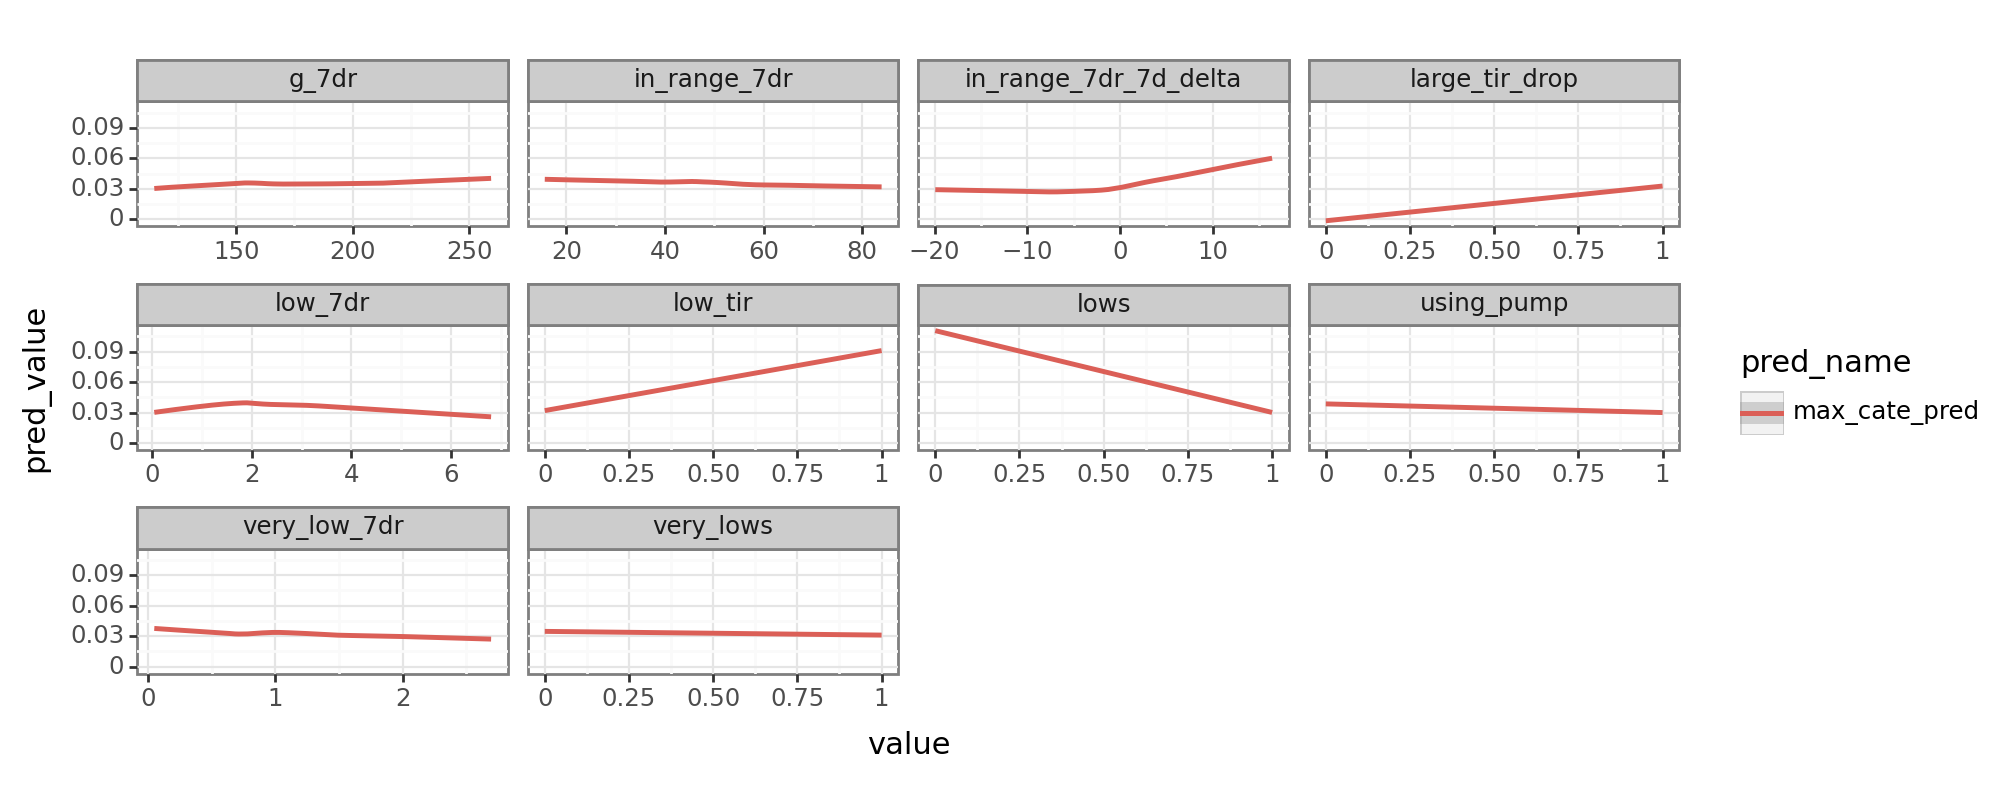

<Figure Size: (1000 x 400)>

In [125]:
# Use Max CATE pred across actions for interpretation #
max_cate_preds = cate_preds.max(axis=1)
pd.DataFrame(max_cate_preds).describe()

# Sanity checks for cate preds
sanity_df = pd.DataFrame(
    np.hstack([X, cate_preds, max_cate_preds.reshape(-1,1), (np.argmax(cate_preds, axis=1) + 1).reshape(-1,1)]),
    columns=STATE_REPS[state_rep] + [f'cate_pred_t{i+1}' for i in range(cate_preds.shape[1])] + ['max_cate_pred', 'best_action'])

# sanity_df = pd.DataFrame(
#     np.hstack([X, max_cate_preds.reshape(-1,1)]),
#     columns=STATE_REPS[state_rep] + ['cate_pred'])

melt_df = pd.melt(sanity_df.sample(n=1000, random_state=123),
                  id_vars=[f'cate_pred_t{i+1}' for i in range(cate_preds.shape[1])] + ['max_cate_pred', 'best_action'])
melt_df = pd.melt(melt_df, id_vars = ['value','variable','best_action'], var_name = 'pred_name', value_name = 'pred_value')

melt_df['p05'] = melt_df.groupby('variable')['value'].transform(lambda x: x.quantile(0.05))
melt_df['p95'] = melt_df.groupby('variable')['value'].transform(lambda x: x.quantile(0.95))

melt_df = melt_df[
    ((melt_df.value>melt_df.p05) & (melt_df.value<melt_df.p95)) | 
    (melt_df.variable.isin(['low_tir','lows','large_tir_drop','very_lows','using_pump']))]

melt_df.loc[melt_df.variable.isin(['very_low_7dr', 'low_7dr', 'in_range_7dr', 'in_range_7dr_7d_delta']), 'value'] = \
    melt_df.loc[melt_df.variable.isin(['very_low_7dr', 'low_7dr', 'in_range_7dr', 'in_range_7dr_7d_delta']), 'value']*100

(
    p9.ggplot(melt_df.query("(pred_name=='max_cate_pred')"), 
              p9.aes(x='value', y='pred_value', color='pred_name')) + p9.geom_smooth(method='lowess') + 
    p9.theme_bw() + p9.facet_wrap('~variable', scales='free_x') +
    p9.theme(figure_size=(10, 4))
)

In [106]:
melt_df.variable.unique()

array(['very_low_7dr', 'low_7dr', 'in_range_7dr', 'g_7dr', 'using_pump',
       'in_range_7dr_7d_delta', 'large_tir_drop', 'low_tir', 'lows',
       'very_lows'], dtype=object)

In [149]:
melt_df['var_plot_name'] = melt_df.variable.map({
    'very_low_7dr': '% Time Very Low\n(past week)',
    'low_7dr': '% Time Low\n(past week)',
    'in_range_7dr': '% Time in Range\n(past week)',
    'g_7dr': 'Mean Glucose\n(past week)',
    'using_pump': 'Using \nInsulin Pump',
    'in_range_7dr_7d_delta': 'Change in %TIR\n(between past two weeks)',
    'large_tir_drop': '>15% TIR Drop\n(between past two weeks)',
    'low_tir': 'TIR < 65%\n(past week)',
    'lows': '% Time Low >= 4%\n(past week)',
    'very_lows': '% Time Very Low >= 1%\n(past week)'
    })

melt_df[['variable','var_plot_name']].drop_duplicates()

,variable,var_plot_name
2,very_low_7dr,% Time Very Low\n(past week)
1000,low_7dr,% Time Low\n(past week)
2000,in_range_7dr,% Time in Range\n(past week)
3000,g_7dr,Mean Glucose\n(past week)
4000,using_pump,Using \nInsulin Pump
5000,in_range_7dr_7d_delta,Change in %TIR\n(between past two weeks)
6000,large_tir_drop,>15% TIR Drop\n(between past two weeks)
7000,low_tir,TIR < 65%\n(past week)
8000,lows,% Time Low >= 4%\n(past week)
9000,very_lows,% Time Very Low >= 1%\n(past week)


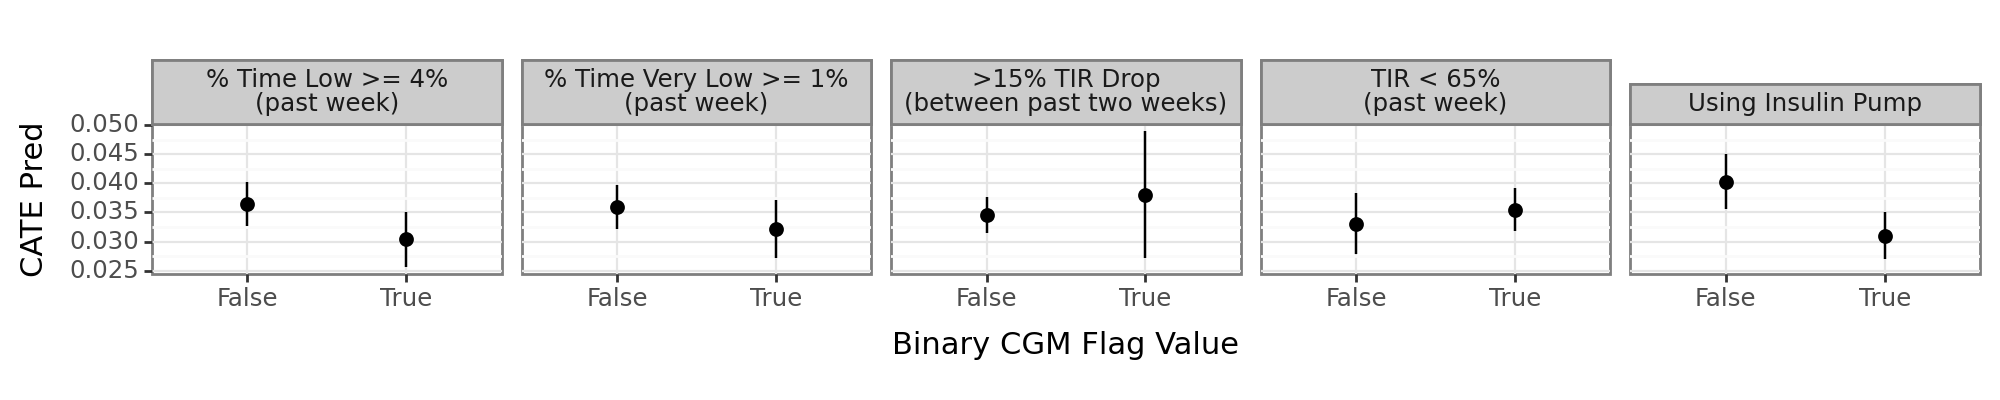

<Figure Size: (1000 x 200)>

In [127]:
p1 = (
    p9.ggplot(melt_df.query("(pred_name=='max_cate_pred') and (variable in ('large_tir_drop','low_tir','using_pump','very_lows','lows'))"), 
              p9.aes(x='factor(value)', y='pred_value')) + p9.stat_summary(fun_data='mean_cl_normal', geom='pointrange') + 
    p9.theme_bw() + p9.facet_wrap('~var_plot_name', scales='free_x', ncol=5) + p9.ylab("CATE Pred") + p9.xlab("Binary CGM Flag Value") +
    p9.theme(figure_size=(10, 2)) +
    p9.scale_x_discrete(labels=lambda l: [f"{'False' if x==0 else 'True'}" for x in l])
)
p1

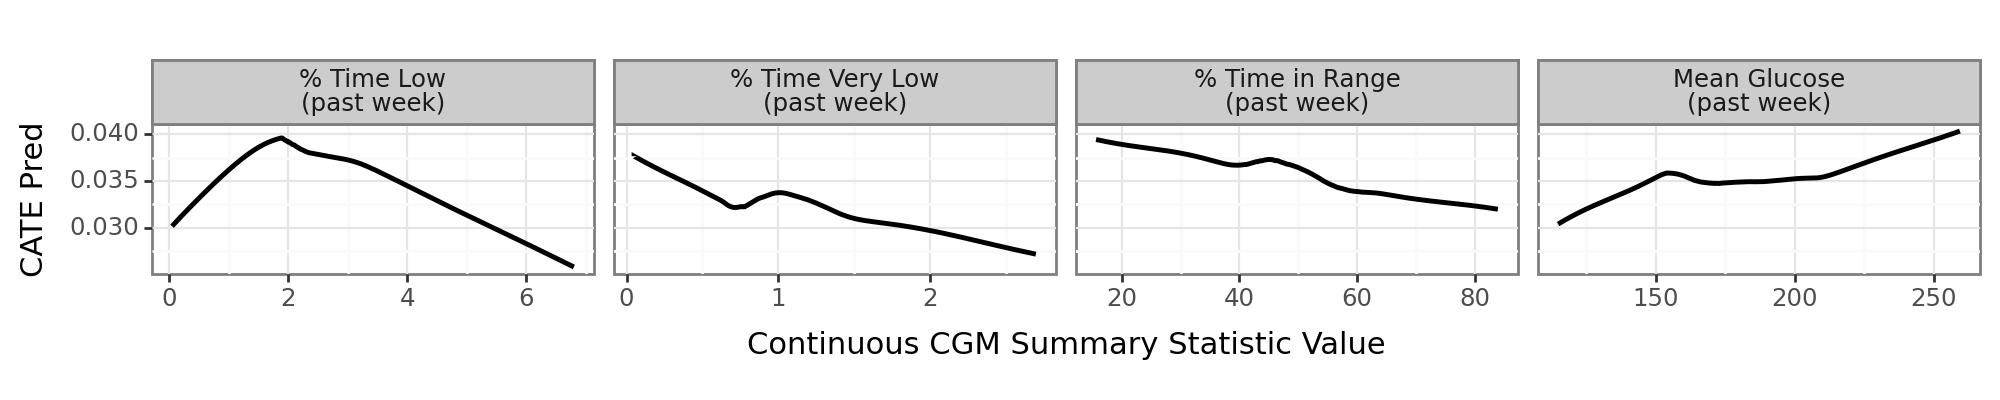

<Figure Size: (1000 x 200)>

In [128]:
p2 = (
    p9.ggplot(melt_df.query("(pred_name=='max_cate_pred') and (variable not in ('in_range_7dr_7d_delta','large_tir_drop','low_tir','using_pump','very_lows','lows'))"), 
              p9.aes(x='value', y='pred_value')) + p9.geom_smooth(method='lowess') + 
    p9.theme_bw() + p9.facet_wrap('~var_plot_name', scales='free_x', ncol=5) + p9.ylab("CATE Pred") + p9.xlab("Continuous CGM Summary Statistic Value") +
    p9.theme(figure_size=(10, 2))
)
p2

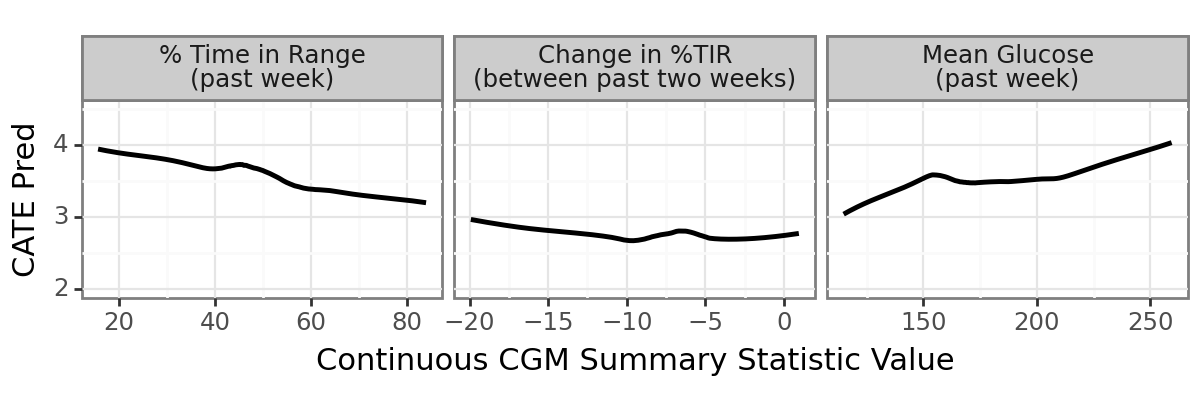

<Figure Size: (600 x 200)>

In [167]:
from mizani.formatters import custom_format
f_melt_df = melt_df[(melt_df.variable!='in_range_7dr_7d_delta') | (melt_df.value<1) ]

p3 = (
    p9.ggplot(f_melt_df.query("(pred_name=='max_cate_pred') and (variable in ('in_range_7dr_7d_delta','in_range_7dr','g_7dr'))"), 
              p9.aes(x='value', y='pred_value*100')) + p9.geom_smooth(method='lowess') + p9.coord_cartesian(ylim=(2,4.5)) +
    p9.theme_bw() + p9.facet_wrap('~var_plot_name', scales='free_x', ncol=3) + p9.ylab("CATE Pred") + p9.xlab("Continuous CGM Summary Statistic Value") +
    p9.theme(figure_size=(6, 2)) +
    p9.scale_y_continuous(breaks=range(2, 5), labels=custom_format("{:.0f}"))
)
p3

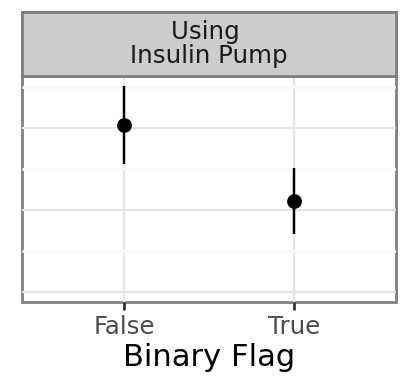

<Figure Size: (200 x 190)>

In [181]:
from mizani.formatters import custom_format
p4 = (
    p9.ggplot(melt_df.query("(pred_name=='max_cate_pred') and (variable == 'using_pump')"), 
              p9.aes(x='factor(value)', y='pred_value*100')) + p9.stat_summary(fun_data='mean_cl_normal', geom='pointrange') + 
    p9.theme_bw() + p9.facet_wrap('~var_plot_name', scales='free_x', ncol=5) + p9.ylab("") + p9.xlab("Binary Flag") +
    p9.coord_cartesian(ylim=(2,4.5)) +
    p9.theme(figure_size=(2, 1.9), axis_text_y=p9.element_blank(), axis_ticks_major_y=p9.element_blank()) +
    p9.scale_x_discrete(labels=lambda l: [f"{'False' if x==0 else 'True'}" for x in l]) +
    p9.scale_y_continuous(breaks=range(2, 5), labels=custom_format("{:.0f}"))
)
p4

In [183]:
# Export as PDF
p1.save(filename='../../output/figures/interpret_bin_flags.pdf', width=10, height=2, units='in', dpi=300)
p2.save(filename='../../output/figures/interpret_cont_vars.pdf', width=10, height=2, units='in', dpi=300)
p3.save(filename='../../output/figures/interpret_cont_vars_2.pdf', width=6, height=2, units='in', dpi=300)
p4.save(filename='../../output/figures/interpret_pump.pdf', width=2, height=1.75, units='in', dpi=300)